In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, Normalizer
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [97]:
%run LinearRegression.ipynb

In [59]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Text(0, 0.5, 'Percentage')

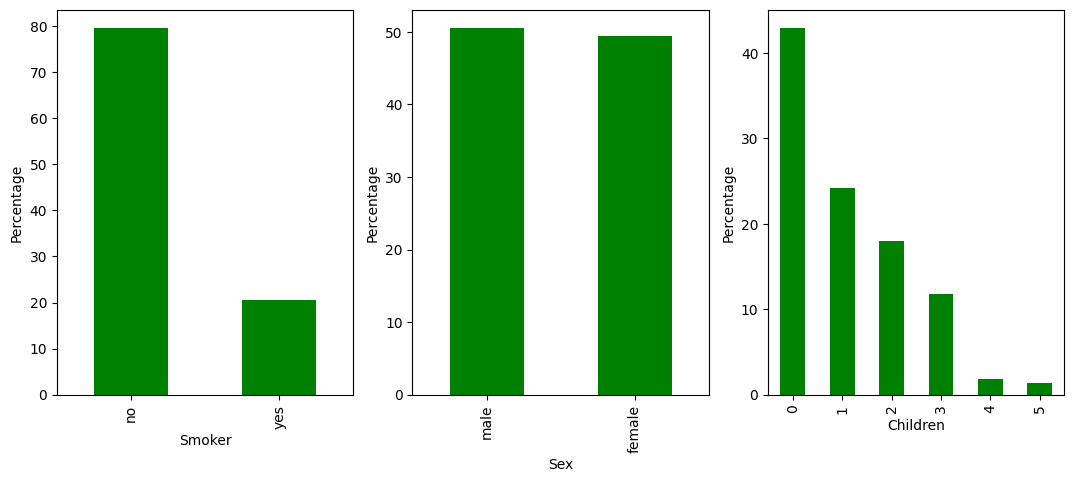

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))
((data.smoker.value_counts(normalize=True))*100).plot(kind='bar', color='green', ax=axs[0])
axs[0].set_xlabel('Smoker')
axs[0].set_ylabel('Percentage')
((data.sex.value_counts(normalize=True))*100).plot(kind='bar', color='green', ax=axs[1])
axs[1].set_xlabel('Sex')
axs[1].set_ylabel('Percentage')
((data.children.value_counts(normalize=True))*100).plot(kind='bar', color='green', ax=axs[2])
axs[2].set_xlabel('Children')
axs[2].set_ylabel('Percentage')

## Pearson Correlation Matrix

In [34]:
numerical_features = ['age', 'bmi', 'charges']
num_corr = data[numerical_features].corr()
num_corr.style.background_gradient(cmap='coolwarm')

,age,bmi,charges
age,1.000000,0.109272,0.299008
bmi,0.109272,1.000000,0.198341
charges,0.299008,0.198341,1.000000


## Cramer's V Correlation Matrix

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            print("Else condition Met: ",v)
    except:
        print("inside error")
        v = 0
    return v
def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(7,7))
    sns.heatmap(cramer,annot=True,fmt='.2f')

    plt.title("Cross Correlation plot on Dataframe with CrammerV Correlation Values")
    plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1a909465d50>,
 'caps': [<matplotlib.lines.Line2D at 0x1a9094854d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a9094653d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a909467e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a90948cb50>],
 'means': []}

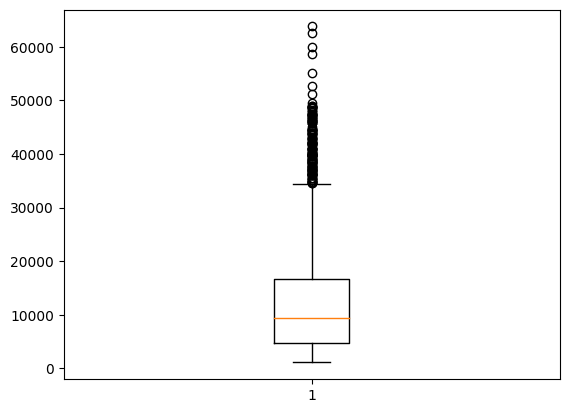

In [39]:
data.charges.describe(include='all')
plt.boxplot(data.charges)

We can see that there are outliers in out data and linear regression is sensitive towards it

C:\Users\mojta\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


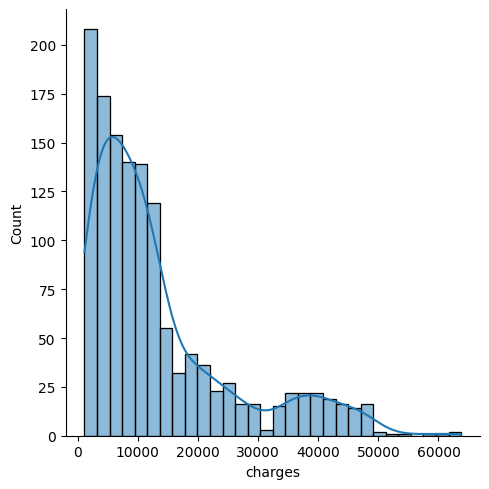

In [51]:
sns.displot(data.charges, kde=True)

We can see that the distribution is positively skewed so the majority of the samples' charges are less that the average
We can use Powertransformer and QuantileTransformer

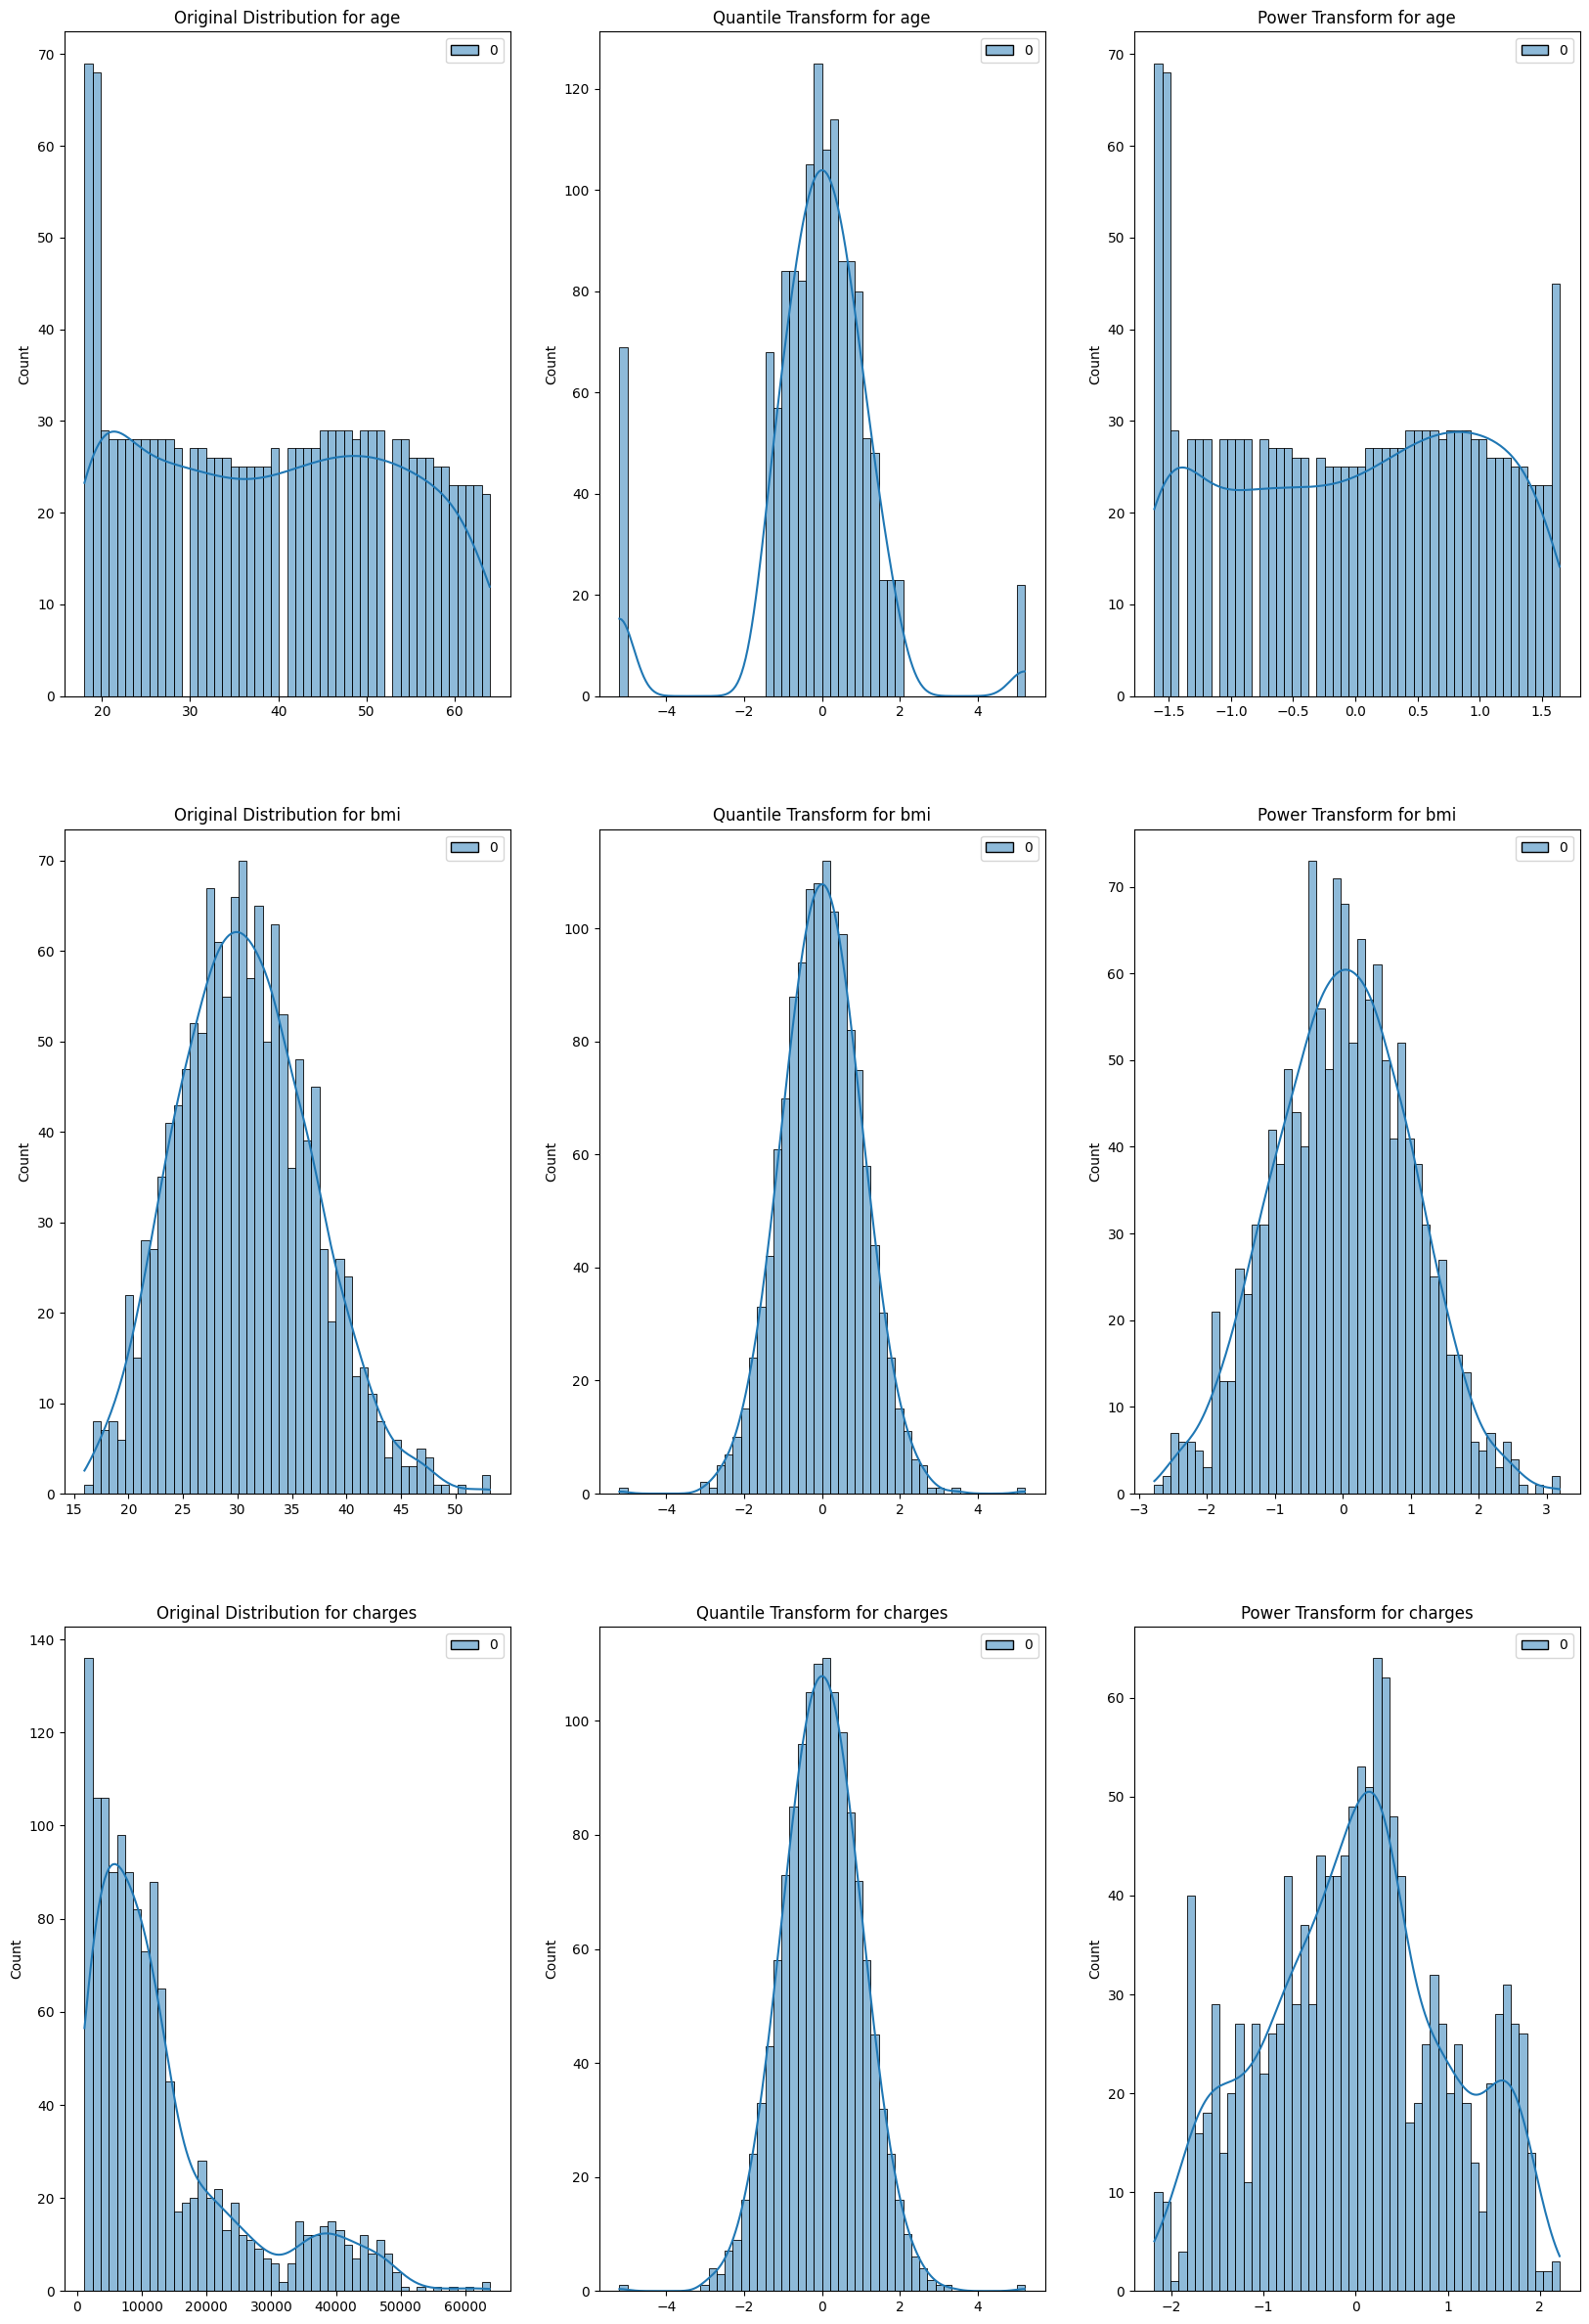

In [55]:
cols1 = numerical_features
def test_transformers(columns):
    pt = PowerTransformer()
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    fig = plt.figure(figsize=(20,30))
    j = 1
    for i in columns:
        array = np.array(data[i]).reshape(-1, 1)
        y = pt.fit_transform(array)
        x = qt.fit_transform(array)
        plt.subplot(3,3,j)
        sns.histplot(array, bins = 50, kde = True)
        plt.title(f"Original Distribution for {i}")
        plt.subplot(3,3,j+1)
        sns.histplot(x, bins = 50, kde = True)
        plt.title(f"Quantile Transform for {i}")
        plt.subplot(3,3,j+2)
        sns.histplot(y, bins = 50, kde = True)
        plt.title(f"Power Transform for {i}")
        j += 3
test_transformers(cols1)

So the QuantileTransformer works better as we can see

In [68]:
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
data_copy_2 = data.copy()
data_copy_2.age =  qt.fit_transform(np.array(data.age).reshape(-1, 1))
data_copy_2.charges = qt.fit_transform(np.array(data.charges).reshape(-1, 1))

In [70]:
one_hot_data = pd.get_dummies(data_copy_2, columns=['children', 'region'])
one_hot_data.sex.replace({'male':1, 'female':0}, inplace=True)
one_hot_data.smoker.replace({'yes':1, 'no':0}, inplace=True)

In [71]:
one_hot_data

,age,sex,bmi,smoker,charges,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.431438,0,27.900,1,0.681430,True,False,False,False,False,False,False,False,False,True
1,-5.199338,1,33.770,0,-1.710334,False,True,False,False,False,False,False,False,True,False
2,-0.578204,1,33.000,0,-0.739820,False,False,False,True,False,False,False,False,True,False
3,-0.303481,1,22.705,0,0.918380,True,False,False,False,False,False,False,True,False,False
4,-0.353856,1,28.880,0,-0.875502,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.593112,1,30.970,0,0.148464,False,False,False,True,False,False,False,True,False,False
1334,-5.199338,0,31.920,0,-1.347299,True,False,False,False,False,False,True,False,False,False
1335,-5.199338,0,36.850,0,-1.979126,True,False,False,False,False,False,False,False,True,False
1336,-1.106438,0,25.800,0,-1.480703,True,False,False,False,False,False,False,False,False,True


In [75]:
normalized = pd.DataFrame(Normalizer().fit_transform(one_hot_data[numerical_features]), columns=numerical_features)
normal_data = one_hot_data.copy()
normal_data.age = normalized.age
normal_data.bmi = normalized.bmi
normal_data.charges = normalized.charges

In [76]:
normal_data.describe()

,age,sex,bmi,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,-0.004732,0.505232,0.997998,0.204783,-0.001052
std,0.053053,0.500160,0.004647,0.403694,0.033825
min,-0.307972,0.000000,0.945356,0.000000,-0.213553
25%,-0.022947,0.000000,0.998518,0.000000,-0.022982
50%,-0.000367,1.000000,0.999293,0.000000,0.000026
75%,0.021475,1.000000,0.999782,0.000000,0.024355
max,0.220349,1.000000,0.999998,1.000000,0.108996


Else condition Met:  0.9985039482211945
Else condition Met:  0.0
Else condition Met:  0.06914461040709625
Else condition Met:  0.0
Else condition Met:  0.0
Else condition Met:  1.0
Else condition Met:  0.03753812565129972
Else condition Met:  0.0
Else condition Met:  0.06914461040709625
Else condition Met:  0.03753812565129972
Else condition Met:  0.9977035380714531
Else condition Met:  0.05698243611684278
Else condition Met:  0.0
Else condition Met:  0.0
Else condition Met:  0.05698243611684278
Else condition Met:  1.0


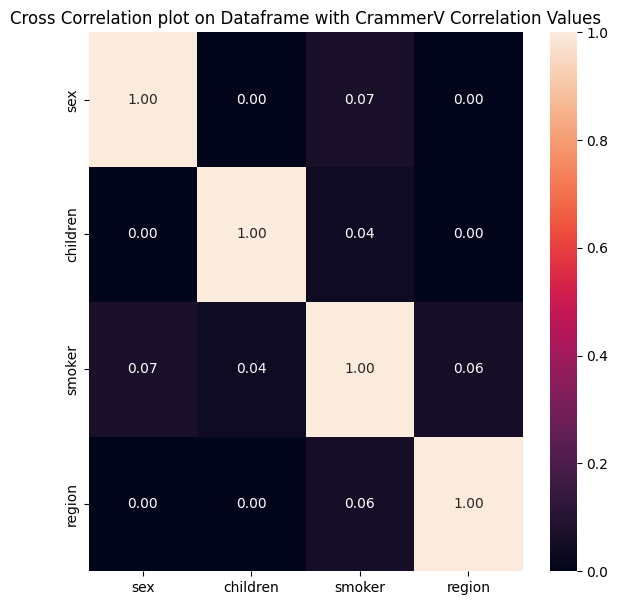

In [36]:
data_copy = data.copy()
categorical_features = ['sex', 'children', 'smoker', 'region']
data_copy['children'].replace({0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}, inplace=True)
plot_cramer(data_copy[categorical_features])

So none of them is close enough to be removed

## Test Train Split

In [79]:
target = normal_data['charges']
features = normal_data.drop(['charges'], axis=1)

In [80]:
train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.3)

# Linear Regression

In [81]:
lr = LinearRegression()

In [82]:
lr.fit(train_x, train_y)

LinearRegression()

In [84]:
pred = lr.predict(test_x)

In [89]:
mean_squared_error(test_y, pred)

0.00040505730104563727

In [99]:
lr2 = LinearRegression()

In [104]:
train_x = train_x.replace({True:1, False:0})

In [105]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 936 entries, 643 to 945
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               936 non-null    float64
 1   sex               936 non-null    int64  
 2   bmi               936 non-null    float64
 3   smoker            936 non-null    int64  
 4   children_0        936 non-null    int64  
 5   children_1        936 non-null    int64  
 6   children_2        936 non-null    int64  
 7   children_3        936 non-null    int64  
 8   children_4        936 non-null    int64  
 9   children_5        936 non-null    int64  
 10  region_northeast  936 non-null    int64  
 11  region_northwest  936 non-null    int64  
 12  region_southeast  936 non-null    int64  
 13  region_southwest  936 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 109.7 KB


In [108]:
test_x = test_x.replace({True:1, False:0})

In [106]:
lr2.fit(train_x, train_y)

In [109]:
pred = lr2.predict(test_x)

In [110]:
mean_squared_error(test_y, pred)

0.0006451938880611826

In [112]:
r2_score(test_y, pred)

0.4283652074849269